In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk as nl
from sklearn import naive_bayes
import seaborn as sns
from nltk.classify.scikitlearn import SklearnClassifier
import random
import tqdm


In [2]:
nl.download('punkt')
nl.download('averaged_perceptron_tagger')
nl.download('cmudict')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sava\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sava\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Sava\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


True

In [3]:
df = pd.read_csv('data\poems\haiku.csv')
df = df.tail(10000)

df = df[['0', '1', '2']]

# get the CMU Pronouncing Dictionary
transcr = nl.corpus.cmudict.dict()

# concatenate data of all columns into one column and word tokenize
df['0'] = df['0'].apply(lambda x: [w.lower() for w in nl.tokenize.word_tokenize(x) if w.isalpha()])
df['1'] = df['1'].apply(lambda x: [w.lower() for w in nl.tokenize.word_tokenize(x) if w.isalpha()])
df['2'] = df['2'].apply(lambda x: [w.lower() for w in nl.tokenize.word_tokenize(x) if w.isalpha()])

def get_syllables(word):
    if word in transcr:
        pron = transcr[word][0]

        # get the number of syllables in the word
        syllable_count = sum(y.isdigit() for x in pron for y in x)
        return syllable_count
    return 0

def syllable_count_for_list(words):
    return sum(get_syllables(word) for word in words)

# check the amount of syllables in the sentence
for ind, row in df.iterrows():
    sentence_syl_count = syllable_count_for_list(row['0'])
    sentence_syl_count += syllable_count_for_list(row['1'])
    sentence_syl_count += syllable_count_for_list(row['2'])

    if(sentence_syl_count != 17):
        df = df.drop(ind)  # haiku must have 17 syllables

print(df.shape)

df['joined_sents'] = df.apply(lambda x: [*x['0'], *x['1'], *x['2']], axis=1)
df['sent_len'] = df.apply(lambda x: [len(x['0']), len(x['1']), len(x['2'])], axis=1)

df['tagged_sents'] = df['joined_sents'].apply(lambda x: nl.pos_tag(x))

df.head(5)

(8472, 3)


,0,1,2,joined_sents,sent_len,tagged_sents
134123,"[i, have, a, really]","[cute, outfit, for, tonight, but]","[i, can, not, find, it]","[i, have, a, really, cute, outfit, for, tonigh...","[4, 5, 5]","[(i, NNS), (have, VBP), (a, DT), (really, RB),..."
134124,"[we, can, hold, our]","[hands, together, through, the, oh]","[oh, through, the, oh, oh]","[we, can, hold, our, hands, together, through,...","[4, 5, 5]","[(we, PRP), (can, MD), (hold, VB), (our, PRP$)..."
134125,"[you, my, hero, man]","[get, well, soon, i, loved, you, since]","[here, in, the, real, world]","[you, my, hero, man, get, well, soon, i, loved...","[4, 7, 5]","[(you, PRP), (my, PRP$), (hero, NN), (man, NN)..."
134126,"[my, biggest, guilty]","[pleasure, is, probably, punk]","[covers, of, pop, songs]","[my, biggest, guilty, pleasure, is, probably, ...","[3, 4, 4]","[(my, PRP$), (biggest, JJS), (guilty, JJ), (pl..."
134127,"[yes, daddy, tie, me]","[up, choke, me, to, dead, and, leave]","[my, body, to, rot]","[yes, daddy, tie, me, up, choke, me, to, dead,...","[4, 7, 4]","[(yes, RB), (daddy, JJ), (tie, NNS), (me, PRP)..."


Total amount of sample 108143
Total classes 9551


C:\Users\Sava\.virtualenvs\crea-2-w6Y9zmrs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,0,1,2,joined_sents,sent_len,tagged_sents
134123,"[i, have, a, really]","[cute, outfit, for, tonight, but]","[i, can, not, find, it]",i,"[4, 5, 5]","[(i, NNS), (have, VBP), (a, DT), (really, RB),..."
134123,"[i, have, a, really]","[cute, outfit, for, tonight, but]","[i, can, not, find, it]",have,"[4, 5, 5]","[(i, NNS), (have, VBP), (a, DT), (really, RB),..."
134123,"[i, have, a, really]","[cute, outfit, for, tonight, but]","[i, can, not, find, it]",a,"[4, 5, 5]","[(i, NNS), (have, VBP), (a, DT), (really, RB),..."


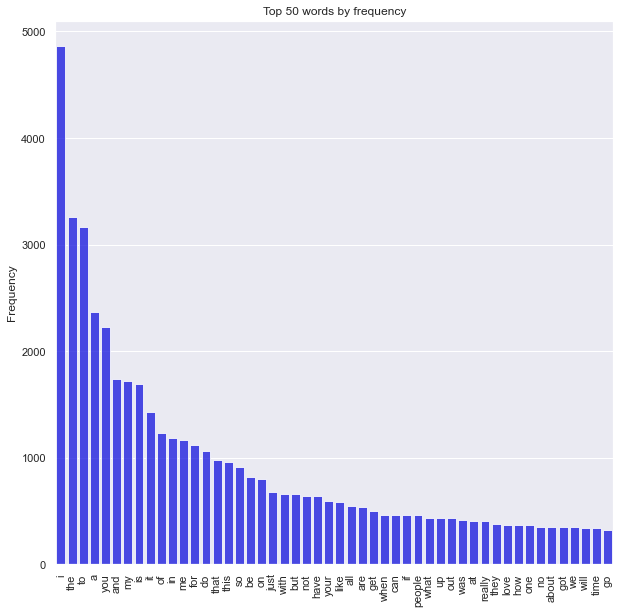

In [4]:
unit = df.explode('joined_sents')

print('Total amount of sample', unit['joined_sents'].count())
print('Total classes', unit['joined_sents'].nunique())


sns.set_theme()

# create new figure
fig, ax = plt.subplots(figsize=(10, 10))

# get the amount of words in each class
data = unit['joined_sents'].value_counts()[:50]
plt.ylabel('Frequency')
plt.title('Top 50 words by frequency')
plt.xticks(rotation=90)
sns.barplot(data.index, data.values, alpha=0.8, color='blue', ax=ax)

unit.head(3)

In [5]:
def pos_features(sentence, i):
    word = sentence[i][0]
    tag = sentence[i][1]

    features = {
        "bias": 1.0,
        "suffix(1)": word[-1:],
        "suffix(2)": word[-2:],
        "suffix(3)": word[-3:],
        "word":word,
        "pos": tag
    }

    # count number of current word in sentence
    features["count"] = sentence.count(word)

    features.update(get_n_word(sentence, i, -1))
    features.update(get_n_word(sentence, i, -2))

    return features


def get_n_word(sentence, i, n):
    if i + n < 0:
        return {
            "SOS": True
        }
    return {
        f'{n}:word': sentence[i + n][0],
        f'{n}:word:pos': sentence[i + n][1],
    }


def get_next_word(sentence, i):
    if i + 1 >= len(sentence):
        return "<END>"
    return sentence[i+1]


featuresets = []
for ind, row in df.iterrows():
    featuresets.append([])
    for i, (word, tag) in list(enumerate(row['tagged_sents']))[:-1]:
        featuresets[-1].append((pos_features(row['tagged_sents'], i), get_next_word(row['joined_sents'], i)))
    
    featuresets[-1].append((pos_features(['SOS'], 0), row['joined_sents'][0]))
    

size = int(len(featuresets) * 0.1)


def flatten(t):
    return [item for sublist in t for item in sublist]


f_f = flatten(featuresets)

train_set, test_set = f_f[size:], f_f[:size]

print('Created splits', len(train_set), len(test_set))
print('Train set', len(train_set), ' samples')
print('Test set', len(test_set), ' samples')

Created splits 107296 847
Train set 107296  samples
Test set 847  samples


In [6]:
classifier = nl.NaiveBayesClassifier.train(train_set)

In [ ]:
# Determine accuracy of classifier
# This operation takes very long for some reason...
print('Accuracy', nl.classify.accuracy(classifier, test_set))

In [27]:
# classifier2 = SklearnClassifier(naive_bayes.MultinomialNB()).train(train_set)

In [11]:
def generate_random_starting_word():
    sample = random.choice(train_set)

    prev_word = sample[0]['word']
    postag = nl.tag.pos_tag([prev_word])[0][1]
    return (prev_word, postag)

def structure_to_index(structure):
    return [sum(structure[:i + 1]) for i in range(len(structure))]

def generate_poem(structure):
    checkpoints = structure_to_index(structure)

    prev_word, postag = generate_random_starting_word()
    poem = [(prev_word, postag)]

    MAX_ITERATIONS = 100

    iteration = 0
    checkpoint = 0
    while iteration < MAX_ITERATIONS:
        # generate the next word
        vector = pos_features(poem, len(poem) - 1)
        prev_word =  classifier.prob_classify(vector).generate()
        postag = nl.tag.pos_tag([prev_word])[0][1]
        
        # Add to poem
        poem.append((prev_word, postag))

        # Check if the poem is valid
        syllables = syllable_count_for_list([w for w, pos in poem])

        # Check if next checkpoint was reached
        if syllables == checkpoints[checkpoint]:
            checkpoint += 1

        # If we have overshot the checkpoint, reset to previous checkpoint
        elif syllables > checkpoints[checkpoint]:
            print('Too many syllables, disposing (part of) poem')
            if checkpoint == 0:
                # clear existing poem
                prev_word, postag = generate_random_starting_word()
                poem = [(prev_word, postag)]
            else:
                # clear last checkpoint
                poem = poem[:checkpoints[checkpoint - 1]]
        
        # As checkpoint is increased we have to check whether or not to exit
        if checkpoint == len(checkpoints):
            return [w for w, pos in poem]

        iteration += 1

    # Throw an error if we can't generate a valid poem
    raise Exception('Could not generate a valid poem')

def display_poem(poem, structure):
    checkpoints = structure_to_index(structure)
    print(checkpoints)

    for i, word in enumerate(poem):
        print(word, end=' ')
        if i + 1 in checkpoints:
            print()
    pass

poem_structure = [5, 7, 5]

poem = generate_poem(poem_structure)
display_poem(poem, poem_structure)


[5, 12, 17]
sad to be a great 
day of the best of the same 
time of a day of 


In [ ]:
for i in tqdm.trange(100):
    poem = generate_poem(poem_structure)